# Tropical Cyclone Risk Assessment

In this notebook, we will perform a **tropical cyclone damage and risk assessment** for education infrastructure. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., secondary schools) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on education infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b12
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely

import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Vietnam'
country_iso3 = 'VNM'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Jamaica. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the healthcare data.

In [5]:
%%time
features = read_osm_data(infrastructure_path,asset_type='education')

CPU times: total: 1min 26s
Wall time: 1min 40s


In [6]:
sub_types = features.object_type.unique()

In [7]:
sub_types

array(['school', 'kindergarten', 'library', 'college', 'university'],
      dtype=object)

And we can explore our data interactively 

In [8]:
viz(features)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/250 Tropical Cyclone wind speed map to showcase the approach.

In [9]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/Wind_T250.tif", engine="rasterio")

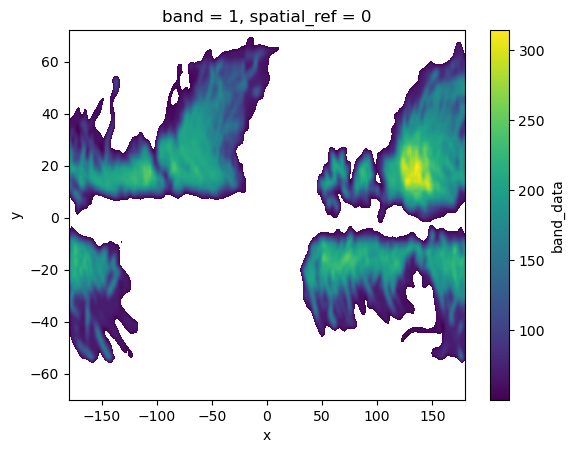

In [10]:
hazard_map.band_data.plot()

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

Locations of education facilities are (somewhat randomly) geotagged as either points or polygons. This matters quite a lot for the maximum damages. For polygons, we would use damage per square meter, whereas for points, we would estimate the damage to the entire asset at once. Here we take the approach of converting the points to polygons, and there define our maximum damages in dollar per square meter. 

In [11]:
maxdam_dict = {'community_centre' : 1000, 
               'school' : 1000, 
               'kindergarten' : 1000, 
               'university' : 1000, 
               'college' : 1000,
               'library' : 1000
              }

To be used in our damage assessment, we convert this to a Pandas DataFrame

In [12]:
maxdam = pd.DataFrame.from_dict(maxdam_dict,orient='index').reset_index()
maxdam.columns = ['object_type','damage']

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics.

In [16]:
vulnerability_path = "https://zenodo.org/records/13889558/files/Table_D2_Hazard_Fragility_and_Vulnerability_Curves_V1.1.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='W_Vuln_V10m')

And let's have a look at all the available options

In [17]:
with pd.option_context('display.max_rows', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
W1.1,Windturbine,"1-MW capacity, 40-m hub height"
W1.1a,Windturbine,"1-MW capacity, 40-m hub height"
W1.1b,Windturbine,"1-MW capacity, 40-m hub height"
W1.2,Windturbine,"2.5-MW capacity, 80-m hub height"
W1.2a,Windturbine,"2.5-MW capacity, 80-m hub height"
W1.2b,Windturbine,"2.5-MW capacity, 80-m hub height"
W1.3,Windturbine,"3.3-MW capacity, 100-m hub height"
W1.3a,Windturbine,"3.3-MW capacity, 100-m hub height"
W1.3b,Windturbine,"3.3-MW capacity, 100-m hub height"


As we do not exactly know which curves we may want to use, we can also run the analysis with all curves. To do so, we select all education-related curves from Nirandjan et al. (2024)'s database.

In [26]:
selected_curves = ['W21.2','W21.3','W21.4','W21.5','W21.10']

The next step is to extract the curves from the database, and prepare them for proper usage into our analysis.

We start by selecting the curve IDs from the larger pandas DataFrame **vul_df**:

In [27]:
damage_curves = vul_df[['ID number']+selected_curves]
damage_curves = damage_curves.iloc[4:125,:]

Then for convenience, we rename the index name to the hazard intensity we are considering. 

In [28]:
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('WindSpeed')  

And make sure that our damage values are in floating numbers. 

In [29]:
damage_curves = damage_curves.astype(np.float32)

And ensure that the columns of the curves link back to the different asset types we are considering:

In [30]:
damage_curves.columns = sub_types

There could be some **NaN** values at the tail of some of the curves. To make sure the code works, we fill up the **NaN** values with the last value of each of the curves. 

In [31]:
damage_curves = damage_curves.fillna(method='ffill')

And create a dictionary that contains a pandas DataFrame for all object types, for each vulnerability curve. 

In [32]:
multi_curves = {}
for unique_curve in unique_curves:
  
    curve_creation = damage_curves.copy()
    
    get_curve_values = vul_df[unique_curve].iloc[4:125].values
    
    for curve in curve_creation:
        curve_creation.loc[:,curve] = get_curve_values

    multi_curves[unique_curve] = curve_creation.astype(np.float32)

### Ancilliary data for processing

In [33]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [34]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Preparing the Data

Clip the hazard data to the country of interest.

In [35]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [36]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

Convert the point data to polygons. We first try to estimate an average size of each building based on each subtype.

To do so, let's first grab the polygon data and estimate their size:

In [37]:
polygon_features = features.loc[features.geometry.geom_type.isin(['Polygon','MultiPolygon'])].to_crs(3857)
polygon_features['square_m2'] = polygon_features.area

In [38]:
square_m2_object_type = polygon_features[['object_type','square_m2']].groupby('object_type').median()

And now we can use this to create polygons, using this square meters as the average size for each point.

In [39]:
features.loc[features.geometry.geom_type == 'Point','geometry'] = features.loc[features.geometry.geom_type == 'Point'].to_crs(3857).apply(lambda x: 
                                                                    shapely.buffer(x.geometry, 
                                                                    distance=np.sqrt(square_m2_object_type.loc[x.object_type,'square_m2']),
                                                                    cap_style='square'),axis=1).set_crs(3857).to_crs(4326)

## 5. Performing the Damage Assessment
We will use the DamageScanner approach. This is a fully optimised damage calculation method, that can capture a wide range of inputs to perform a damage assessment. We will first perform this using only a single damage curve.

In [40]:
%%time
damage_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate(disable_progress=False)

Calculating damage: 100%|█████████████████████████████████████████████████████| 10073/10073 [00:00<00:00, 18320.18it/s]

CPU times: total: 31.9 s
Wall time: 45.3 s


And run this also with the range of vulnerability curves.

In [41]:
%%time
all_results = DamageScanner(hazard_country, features, damage_curves, maxdam).calculate(multi_curves=multi_curves)

Calculating damage: 100%|█████████████████████████████████████████████████████| 10073/10073 [00:00<00:00, 18328.29it/s]

CPU times: total: 32.3 s
Wall time: 44.9 s


## 5. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit 

In [42]:
hazard = 'tropical_cyclones'
return_period = '1_250'
damage_results.to_csv(f'Education_Damage_{country_full_name}_{hazard}_{return_period}.csv')

In [43]:
admin1_country = admin1.loc[admin1.sov_a3 == country_iso3]

In [44]:
damage_results = damage_results.sjoin(admin1_country[['adm1_code','name','geometry']])

In [45]:
admin1_damage = admin1_country.merge(damage_results[['name','damage']].groupby('name').sum(),
                                     left_on='name',
                                     right_on='name',
                                     how='outer')[['name','adm1_code','geometry','damage']]

In [46]:
admin1_damage.to_csv(f'Admin1_Eduation_Damage_{country_full_name}_{hazard}_{return_period}.csv')

## 6. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

And create a distribution of the damages.

<Axes: xlabel='damage', ylabel='Count'>

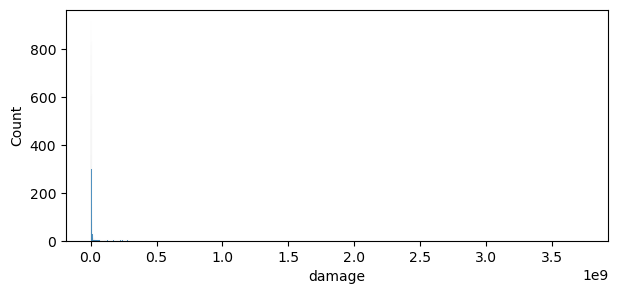

In [47]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))

sns.histplot(data=damage_results,x='damage',ax=ax)

Plot location of most damaged healthcare facilities

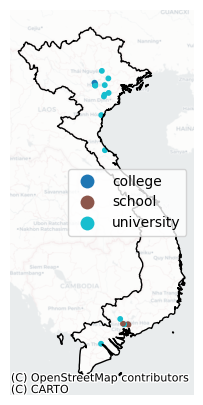

In [48]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

subset = damage_results.to_crs(3857).sort_values('damage',ascending=False).head(20)
subset.geometry = subset.centroid
subset.plot(ax=ax,column='object_type',markersize=10,legend=True)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

In [49]:
viz(damage_results)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

## 7. Performing the Risk Assessment
To do so, we need to select the return periods we want to include, and create a dictioniary as input. We will create this below.

In [50]:
return_periods = [25,50,100,250] 

hazard_dict = {}
collect_max_pres = []
for return_period in return_periods:
    hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/Wind_T{return_period}.tif", engine="rasterio")

    hazard_dict[return_period] = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )
    collect_max_pres.append(hazard_map.band_data.max().values)    

And below we will run a multi-curve risk assessment.

In [51]:
risk_results = DamageScanner(hazard_country, features, damage_curves, maxdam).risk(hazard_dict,multi_curves=multi_curves)

Risk Calculation: 100%|██████████████████████████████████████████████████████████████████| 4/4 [02:40<00:00, 40.21s/it]


## 7. Performing the Risk Assessment under Climate Change
To do so, we need to select the return periods we want to include, and create a dictioniary as input. We will create this below.

In [52]:
return_periods = [25,50,100,250] 

hazard_dict_future = {}
collect_max = []
for return_period in return_periods:
    hazard_map = xr.open_dataset(f"https://hazards-data.unepgrid.ch/Wind_CC_T{return_period}.tif", engine="rasterio")

    hazard_dict_future[return_period] = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )
    collect_max.append(hazard_map.band_data.max().values)

In [53]:
risk_results_future = DamageScanner(hazard_country, features, damage_curves, maxdam).risk(hazard_dict_future,multi_curves=multi_curves)

Risk Calculation: 100%|██████████████████████████████████████████████████████████████████| 4/4 [02:37<00:00, 39.28s/it]


## 8. Visualize the risk results

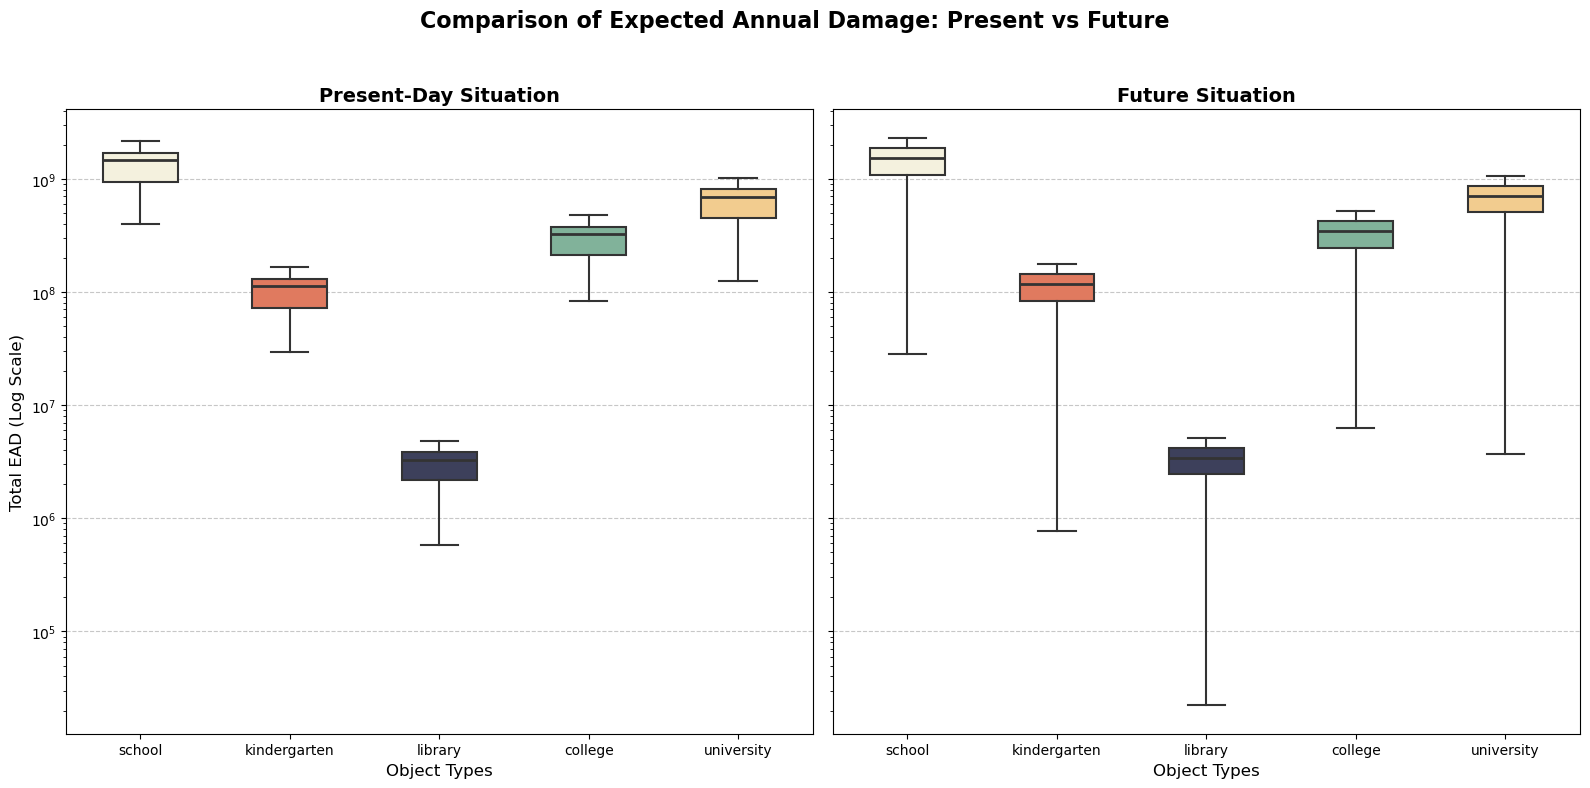

In [54]:
# Create a figure with 2 subplots (2 rows, 1 column)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Define line color and colors for boxes
colors = ['#f4f1de', '#e07a5f', '#3d405b', '#81b29a', '#f2cc8f']
line_color = '#333333'

# --- Left plot: Present day ---
grouped_present = risk_results[['object_type'] + unique_curves].groupby('object_type').sum()
boxplot_present = grouped_present.T.boxplot(column=list(sub_types), grid=False, patch_artist=True, ax=axes[0], return_type='dict')

# Customize present day plot
for box, color in zip(boxplot_present['boxes'], colors):
    box.set_facecolor(color)
    box.set_edgecolor(line_color)
    box.set_linewidth(1.5)

for whisker in boxplot_present['whiskers']:
    whisker.set_color(line_color)
    whisker.set_linewidth(1.5)

for cap in boxplot_present['caps']:
    cap.set_color(line_color)
    cap.set_linewidth(1.5)

for median in boxplot_present['medians']:
    median.set_color(line_color)
    median.set_linewidth(2)

for flier in boxplot_present['fliers']:
    flier.set_markerfacecolor(line_color)
    flier.set_markeredgecolor(line_color)

axes[0].set_title('Present-Day Situation', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total EAD (Log Scale)', fontsize=12)
axes[0].set_xlabel('Object Types', fontsize=12)
axes[0].set_yscale('log')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=0, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# --- Right plot: Future situation ---
grouped_future = risk_results_future[['object_type'] + unique_curves].groupby('object_type').sum()
boxplot_future = grouped_future.T.boxplot(column=list(sub_types), grid=False, patch_artist=True, ax=axes[1], return_type='dict')

# Customize future plot
for box, color in zip(boxplot_future['boxes'], colors):
    box.set_facecolor(color)
    box.set_edgecolor(line_color)
    box.set_linewidth(1.5)

for whisker in boxplot_future['whiskers']:
    whisker.set_color(line_color)
    whisker.set_linewidth(1.5)

for cap in boxplot_future['caps']:
    cap.set_color(line_color)
    cap.set_linewidth(1.5)

for median in boxplot_future['medians']:
    median.set_color(line_color)
    median.set_linewidth(2)

for flier in boxplot_future['fliers']:
    flier.set_markerfacecolor(line_color)
    flier.set_markeredgecolor(line_color)

axes[1].set_title('Future Situation', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Object Types', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].tick_params(axis='x', rotation=0, labelsize=10)

# Add overall title
fig.suptitle('Comparison of Expected Annual Damage: Present vs Future', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()
